In [3]:
def get_filter(name, T, rolloff=None):
    def rc(t, beta):
        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return np.sinc(t)*np.cos(np.pi*beta*t)/(1-(2*beta*t)**2)
    def rrc(t, beta):
        return (np.sin(np.pi*t*(1-beta))+4*beta*t*np.cos(np.pi*t*(1+beta)))/(np.pi*t*(1-(4*beta*t)**2))
        
    # rolloff is ignored for triang and rect
    if name == 'rect':
        return lambda t: (abs(t/T)<0.5).astype(int)    
    if name == 'triang': 
        return lambda t: (1-abs(t/T)) * (abs(t/T)<1).astype(float)
    elif name == 'rc':
        return lambda t: rc(t/T, rolloff)
    elif name == 'rrc':
        return lambda t: rrc(t/T, rolloff)

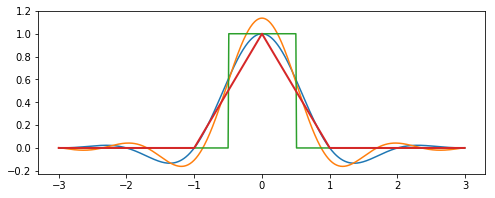

In [9]:
import matplotlib.pyplot as plt 
T = 1
Fs = 100
t = np.arange(-3*T, 3*T, 1/Fs)
g = get_filter('rc', T, rolloff=0.5)  # RC filter with rolloff alpha=0.5
plt.figure(figsize=(8,3))
plt.plot(t, get_filter('rc', T, rolloff=0.5)(t), label=r'Raised cosine $\alpha=0.5$')
plt.plot(t, get_filter('rrc', T, rolloff=0.5)(t), label=r'Root raised cosine $\alpha=0.5$')
plt.plot(t, get_filter('rect', T)(t), label=r'Rectangular')
plt.plot(t, get_filter('triang', T)(t), label=r'Triangular', lw=2)

In [10]:
b = np.array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])
d = 2*b-1
print ("d=%s" % d)

d=[-1  1  1 -1 -1  1  1 -1  1 -1 -1  1  1 -1  1 -1]


In [11]:
def get_signal(g, d):
    """Generate the transmit signal as sum(d[k]*g(t-kT))"""
    t = np.arange(-2*T, (len(d)+2)*T, 1/Fs)
    g0 = g(np.array([1e-8]))
    xt = sum(d[k]*g(t-k*T) for k in range(len(d)))
    return t, xt/g0

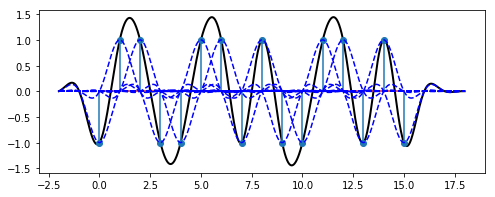

In [12]:
fig = plt.figure(figsize=(8,3))
t, xt = get_signal(g, d)
plt.plot(t, xt, 'k-', lw=2, label='$x(t)$')
plt.stem(T*np.arange(len(d)), d)
for k in range(len(d)):
        plt.plot(t, d[k]*g(t-k*T), 'b--', label='$d[k]g(t-kT)$')

In [13]:
def showEyeDiagramDrawing(xt, T, partInd):
    plt.subplot(211)
    plt.plot(t, xt, 'k-', lw=1, label='$x(t)$') # Plot the overall signal
    
    sigStart = 2*T*Fs  # ignore some transient effects at the beginning of the signal
    samples_perT = Fs*T
    samples_perWindow = 2*T*Fs
    # extract the part of the signal we use for the current part of the eye diagram
    sig_part = xt[sigStart + samples_perT*partInd + np.arange(samples_perWindow)]
    t_emphasize = np.arange(2*T+T*partInd, 2*T+T*partInd+2*T, 1/Fs) + t.min()
    # mark the part of the signal that currently contributes to the eye diagram
    plt.plot(t_emphasize, sig_part, 'b-', lw=2)   
    
    
    plt.subplot(235)
    t_part = np.arange(-T, T, 1/Fs)
    # draw all parts of the eye diagram from previous signal portions in black
    for p in range(partInd):
        plt.plot(t_part, xt[sigStart + samples_perT*p + np.arange(samples_perWindow)], 'k-')
    # draw the current part of the eye diagram in thick blue
    plt.plot(t_part, sig_part, 'b-', lw=2)

In [14]:
def drawFullEyeDiagram(xt):
    """Draw the eye diagram using all parts of the given signal xt"""
    samples_perT = Fs*T
    samples_perWindow = 2*Fs*T
    parts = []
    startInd = 2*samples_perT   # ignore some transient effects at beginning of signal
    
    for k in range(int(len(xt)/samples_perT) - 6):
        parts.append(xt[startInd + k*samples_perT + np.arange(samples_perWindow)])
    parts = np.array(parts).T
    
    t_part = np.arange(-T, T, 1/Fs)
    plt.plot(t_part, parts, 'b-')
    
def drawSignals(g, data=None):
    """Draw the transmit signal, the used filter and the resulting eye-diagram
    into one figure."""
    N = 100;
    if data is None:
        data = 2*((np.random.randn(N)>0))-1
        # fix the first 10 elements for  keeping the shown graphs constant
        # between eye diagrams
        data[0:10] = 2*np.array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0])-1
    
    t, xt = get_signal(g, data)

    plt.subplot(223)
    t_g = np.arange(-4*T, 4*T, 1/Fs)
    plt.plot(t_g, g(t_g))

    
    plt.subplot(211)
    plt.plot(t, xt)
    plt.stem(data)
    
    plt.subplot(224)
    drawFullEyeDiagram(xt); plt.ylim((-2,2))
    plt.tight_layout()

In [16]:
def showRCEyeDiagram(alpha):
    g = get_filter('rc', T=1, rolloff=alpha)
    drawSignals(g)

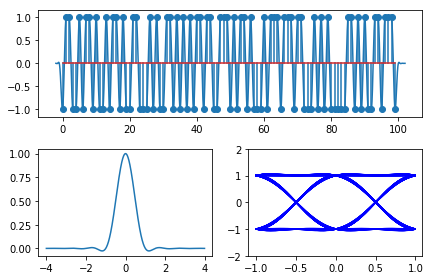

In [17]:
showRCEyeDiagram(alpha=1)

In [18]:
d = 2*np.array([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]) - 1
print ("d=%s" % d)

d=[-1  1 -1 -1  1  1 -1  1 -1 -1 -1  1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1
  1 -1  1  1  1 -1  1]


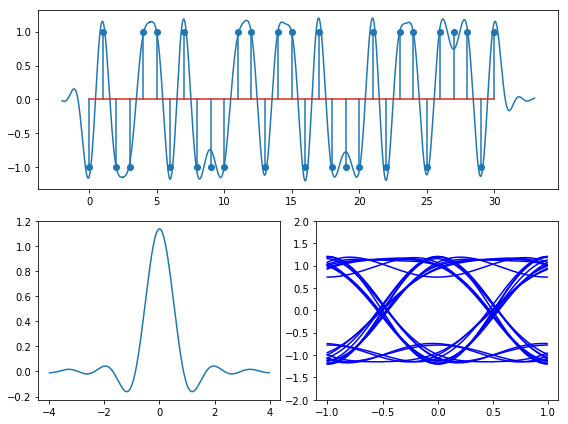

In [19]:
plt.figure(figsize=(8,6))
drawSignals(get_filter('rrc', T=1, rolloff=0.5), data=d)

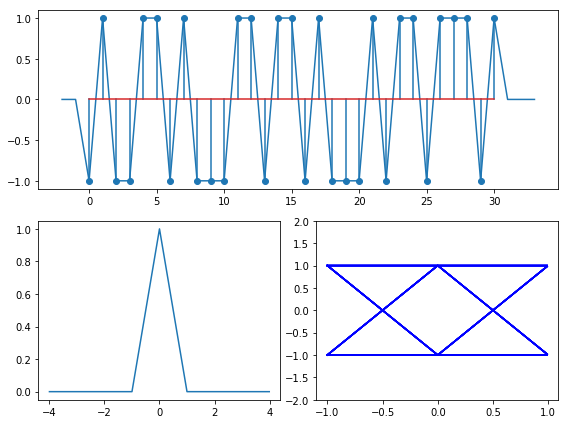

In [20]:
plt.figure(figsize=(8,6))
drawSignals(get_filter('triang', T=1), data=d)

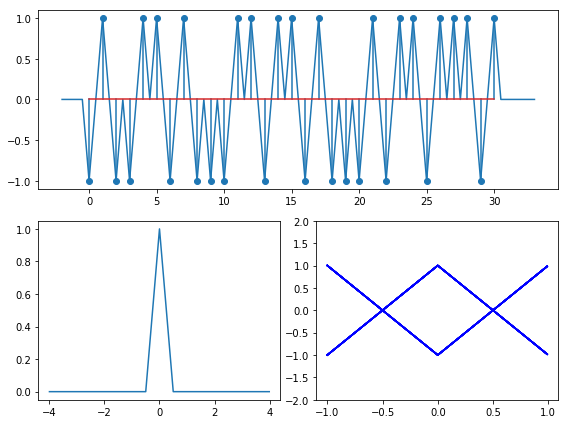

In [21]:
plt.figure(figsize=(8,6))
drawSignals(get_filter('triang', T=0.5, rolloff=0.5), data=d)

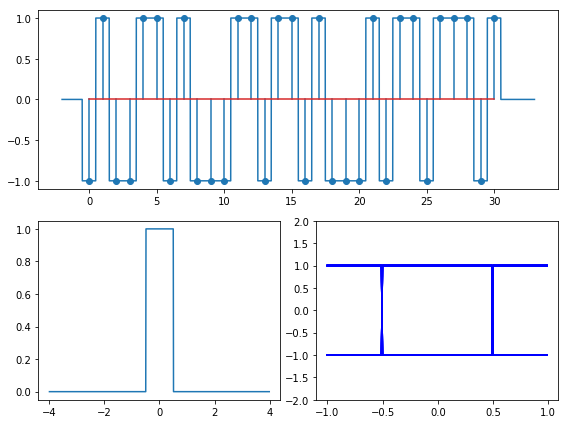

In [22]:
plt.figure(figsize=(8,6))
drawSignals(get_filter('rect', T=1, rolloff=0.5), data=d)

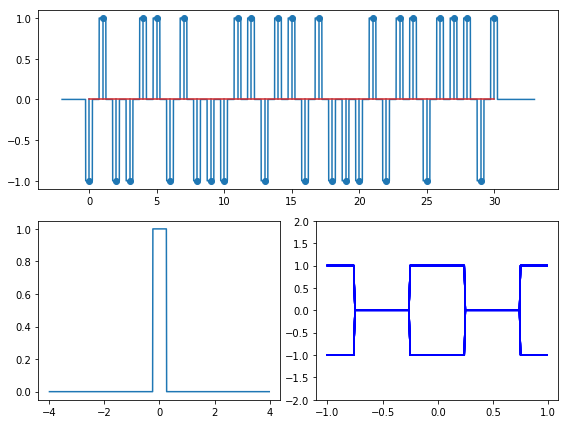

In [23]:
plt.figure(figsize=(8,6))
drawSignals(get_filter('rect', T=0.5, rolloff=0.5), data=d)


[ 1  1  1  3  3  3 -1 -3  1 -3]


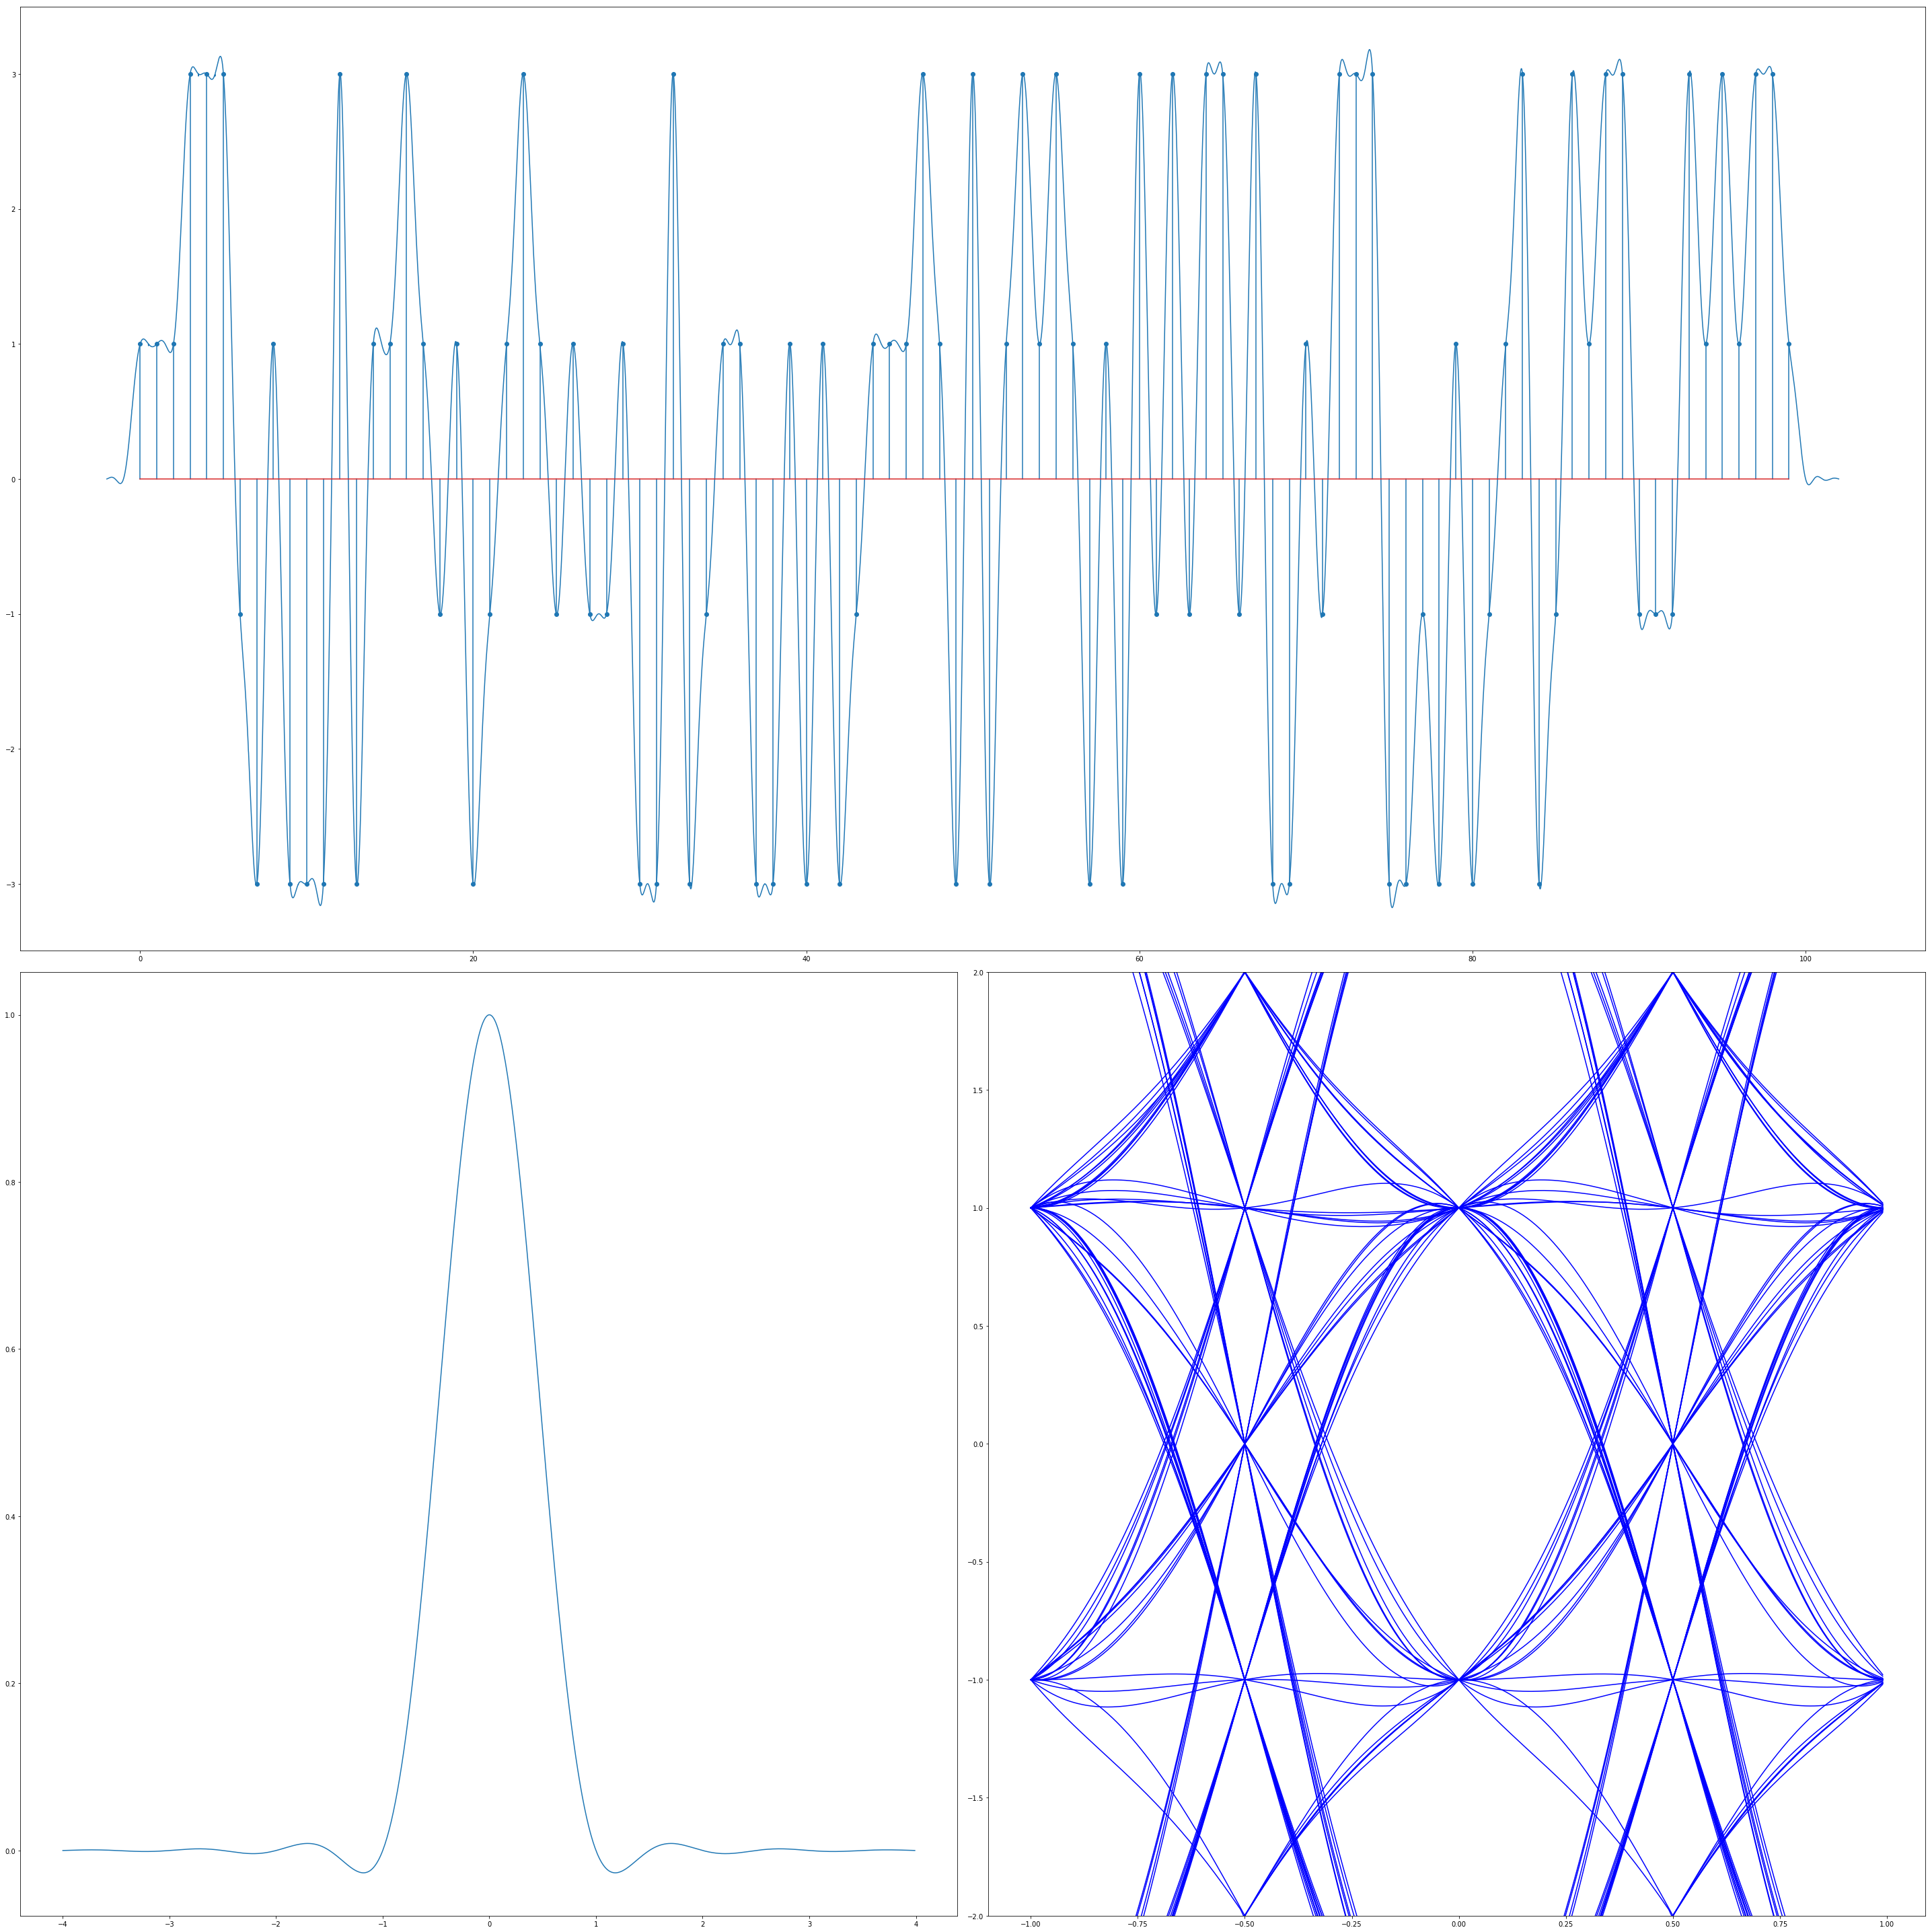

In [34]:
N = 100
plt.figure(figsize=(40,40))
data = 3-2*np.arange(4)[np.random.randint(4, size=N)]
#data = 3-2*np.arange(4)[np.random.randint(4)]
print (data[:10])
drawSignals(get_filter('rc', T=1, rolloff=1), data=data)

The cython version of the curve counter is not available.


AttributeError: 'AxesSubplot' object has no attribute 'set_axis_color'

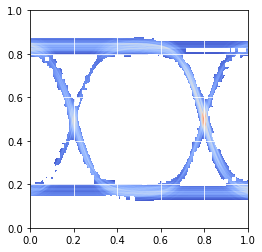

In [38]:
import numpy as np

use_fast = True
try:
    from brescount import bres_curve_count
except ImportError:
    print ("The cython version of the curve counter is not available.")
    use_fast = False


def bres_segment_count_slow(x0, y0, x1, y1, grid):
    """Bresenham's algorithm.

    The value of grid[x,y] is incremented for each x,y
    in the line from (x0,y0) up to but not including (x1, y1).
    """

    nrows, ncols = grid.shape

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    sx = 0
    if x0 < x1:
        sx = 1
    else:
        sx = -1
    sy = 0
    if y0 < y1:
        sy = 1
    else:
        sy = -1

    err = dx - dy

    while True:
        # Note: this test is moved before setting
        # the value, so we don't set the last point.
        if x0 == x1 and y0 == y1:
            break

        if 0 <= x0 < nrows and 0 <= y0 < ncols:
            grid[x0, y0] += 1

        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

def bres_curve_count_slow(x, y, grid):
    for k in range(x.size - 1):
        x0 = x[k]
        y0 = y[k]
        x1 = x[k+1]
        y1 = y[k+1]
        bres_segment_count_slow(x0, y0, x1, y1, grid)


def random_trace(t):
    s = 2*(np.random.randint(0, 5) % 2) - 1
    r = 0.01 * np.random.randn()
    s += r
    a = 2.0 + 0.001 * np.random.randn()
    q = 2*(np.random.randint(0, 7) % 2) - 1
    t2 = t + q*(6 + 0.01*np.random.randn())
    t2 += 0.05*np.random.randn()*t
    y = a * (np.exp(s*t2) / (1 + np.exp(s*t2)) - 0.5) + 0.07*np.random.randn()
    return y


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    grid_size = 600
    grid = np.zeros((grid_size, grid_size), dtype=np.int32)

    tmin = -10.0
    tmax = 10.0
    n = 81
    t = np.linspace(tmin, tmax, n)
    dt = (tmax - tmin) / (n - 1)

    ymin = -1.5
    ymax = 1.5

    num_traces = 1000

    for k in range(num_traces):

        # Add some noise to the times at which the signal
        # will be sampled.  Without this, all the samples occur
        # at the same times, and this produces an aliasing
        # effect in the resulting bin counts.
        # If n == grid_size, this can be dropped, and t2 = t
        # can be used instead. (Or, implement an antialiased
        # version of bres_curve_count.)
        steps = dt + np.sqrt(0.01 * dt) * np.random.randn(n)
        steps[0] = 0
        steps_sum = steps.cumsum()
        t2 = tmin + (tmax - tmin) * steps_sum / steps_sum[-1]

        td = (((t2 - tmin) / (tmax - tmin)) * grid_size).astype(np.int32)

        y = random_trace(t2)

        # Convert y to integers in the range [0,grid_size).
        yd = (((y - ymin) / (ymax - ymin)) * grid_size).astype(np.int32)

        if use_fast:
            bres_curve_count(td, yd, grid)
        else:
            bres_curve_count_slow(td, yd, grid)

    plt.figure()
    # Convert to float32 so we can use nan instead of 0.
    grid = grid.astype(np.float32)
    grid[grid==0] = np.nan
    plt.grid(color='w')
    plt.imshow(grid.T[::-1,:], extent=[0,1,0,1], cmap=plt.cm.coolwarm,
               interpolation='gaussian')
    ax = plt.gca()
    #ax.set_axis_bgcolor('k')
    ax.set_axis_color('k')
    ax.set_xticks(np.linspace(0,1,11))
    ax.set_yticks(np.linspace(0,1,11))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.colorbar()
    fig = plt.gcf()

    #plt.savefig("eye-diagram.png", bbox_inches='tight')
    plt.show()

In [45]:
%pylab inline
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


C:\Users\Usuario\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


ModuleNotFoundError: No module named 'sk_dsp_comm'